In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.9.1



In [24]:
# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of MOVEMENTs that data is available for
MOVEMENTS = [
    "middle",
    "much",
    "no",
]

SAMPLES_PER_MOVEMENT = 5

NUM_MOVEMENTS = len(MOVEMENTS)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_MOVEMENTS = np.eye(NUM_MOVEMENTS)

inputs = []
outputs = []

In [25]:
# read each csv file and push an input and output
for MOVEMENT_index in range(NUM_MOVEMENTS):
  MOVEMENT = MOVEMENTS[MOVEMENT_index]
  print(f"Processing index {MOVEMENT_index} for MOVEMENT '{MOVEMENT}'.")
  
  output = ONE_HOT_ENCODED_MOVEMENTS[MOVEMENT_index]
  
  df = pd.read_csv("data_" + MOVEMENT + "_motion.csv",sep=',')
  # calculate the number of MOVEMENT recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_MOVEMENT)
  
  print(f"\tThere are {num_recordings} recordings of the {MOVEMENT} MOVEMENT.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_MOVEMENT):
      index = i * SAMPLES_PER_MOVEMENT + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      tensor += [
          (df['accel_x'][index] + 4) / 8,
          (df['accel_y'][index] + 4) / 8,
          (df['accel_z'][index] + 4) / 8,
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)
print("Data set parsing and preparation complete.")

Processing index 0 for MOVEMENT 'middle'.
	There are 12 recordings of the middle MOVEMENT.
Processing index 1 for MOVEMENT 'much'.
	There are 8 recordings of the much MOVEMENT.
Processing index 2 for MOVEMENT 'no'.
	There are 12 recordings of the no MOVEMENT.
Data set parsing and preparation complete.


In [26]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [27]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_MOVEMENTS, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/600
19/19 [==============================] - 0s 6ms/step - loss: 0.2334 - mae: 0.4525 - val_loss: 0.2231 - val_mae: 0.4429
Epoch 2/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2208 - mae: 0.4395 - val_loss: 0.2337 - val_mae: 0.4521
Epoch 3/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2166 - mae: 0.4331 - val_loss: 0.2437 - val_mae: 0.4623
Epoch 4/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2152 - mae: 0.4348 - val_loss: 0.2525 - val_mae: 0.4689
Epoch 5/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2116 - mae: 0.4277 - val_loss: 0.2552 - val_mae: 0.4685
Epoch 6/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2107 - mae: 0.4251 - val_loss: 0.2552 - val_mae: 0.4665
Epoch 7/600
19/19 [==============================] - 0s 2ms/step - loss: 0.2099 - mae: 0.4213 - val_loss: 0.2584 - val_mae: 0.4729
Epoch 8/600
19/19 [==============================] - 0s 3ms/step - loss: 0.2094 - m

# Visualize training

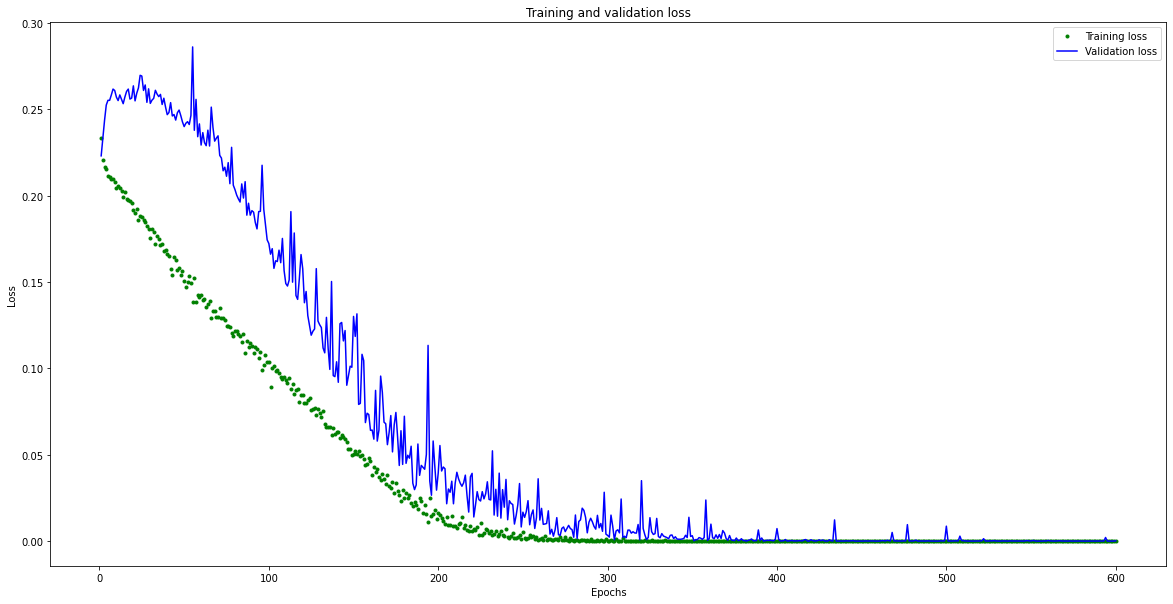

[20.0, 10.0]


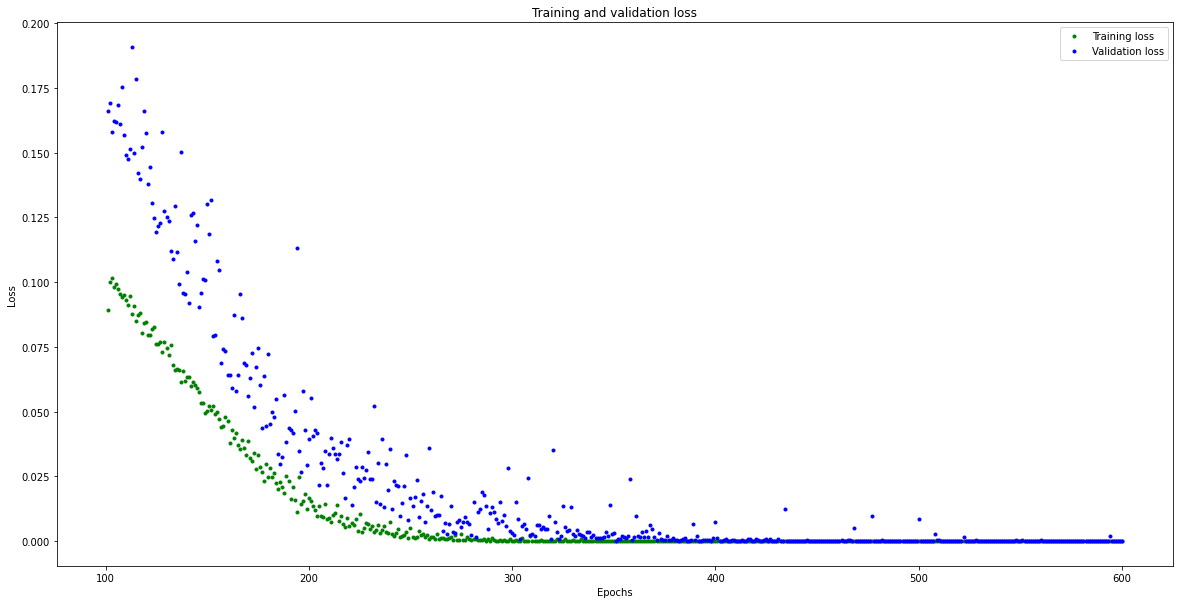

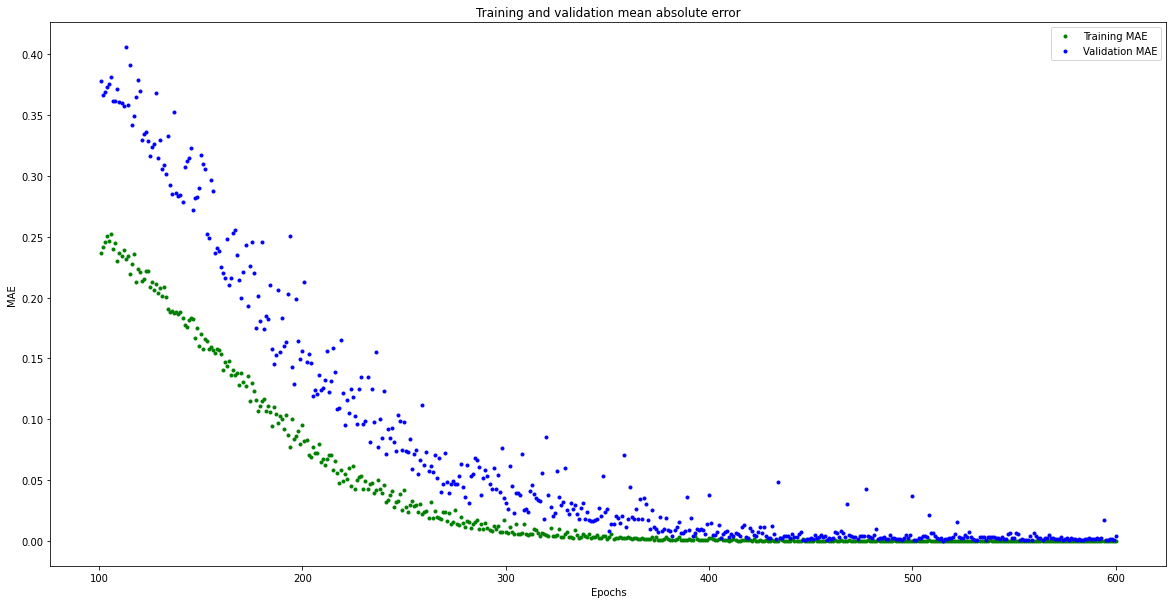

In [28]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [29]:

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\timm_\AppData\Local\Temp\tmp2cgps5iu\assets


INFO:tensorflow:Assets written to: C:\Users\timm_\AppData\Local\Temp\tmp2cgps5iu\assets


Model is 8520 bytes


In [30]:

!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")
import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Das System kann den angegebenen Pfad nicht finden.
Der Befehl "cat" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Das System kann den angegebenen Pfad nicht finden.


FileNotFoundError: [WinError 2] Das System kann die angegebene Datei nicht finden: 'model.h'